In [19]:
import torch
import numpy as np
from torchvision.io import image as torch_image
import cv2
import pathlib
import torchvision
from scipy.ndimage.measurements import label
from PIL.Image import Image, open as im_open
import PIL.Image

/tmp/ipykernel_1053325/4200020444.py:7: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [20]:
def remove_noise(mask, kernel_size=3, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=iterations)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    return closing


In [21]:
def mask_to_bboxes(mask, threshold=0.5, remove_noise_flag=True):
    if remove_noise_flag:
        mask = remove_noise(mask)

    # Apply threshold to create a binary mask
    binary_mask = mask

    # Label connected components
    labeled_array, num_features = label(binary_mask)

    bboxes = []
    for i in range(1, num_features + 1):
        # Get the individual component mask
        component_mask = (labeled_array == i)

        # Find the coordinates of the bounding box
        y_coords, x_coords = np.where(component_mask)
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()

        bboxes.append([x_min, y_min, x_max, y_max])

    return bboxes


In [22]:
pred_dir = pathlib.Path("/home/fummicc1/codes/signate/") / "test" / "modern" / "predicted"

In [23]:
CLASS_MAP = {  
  0: "0_background",
  1: "2_handwritten",
  2: "3_typography",
  3: "4_illustration",
  4: "5_stamp",
  5: "6_headline",
  6: "7_caption",
  7: "8_textline",
}

/home/fummicc1/codes/signate/test/modern/predicted/test_925707_0033.jpg
Bounding boxes: [[397, 145, 397, 145], [499, 146, 499, 146], [202, 147, 213, 154], [397, 147, 564, 162], [1046, 150, 1210, 164], [854, 152, 888, 164], [1389, 153, 1400, 161], [729, 154, 729, 154], [734, 154, 734, 154], [204, 156, 204, 156], [723, 156, 759, 168], [852, 157, 852, 157], [213, 158, 213, 158], [854, 163, 854, 163], [1209, 163, 1209, 163], [1389, 163, 1389, 163], [1164, 165, 1164, 165], [1196, 165, 1196, 165], [267, 179, 298, 196], [306, 179, 332, 201], [306, 180, 306, 180], [330, 180, 330, 180], [304, 181, 304, 181], [191, 182, 214, 197], [350, 182, 370, 199], [500, 182, 520, 198], [1217, 184, 1297, 198], [564, 185, 564, 185], [634, 185, 634, 185], [1137, 185, 1160, 222], [1301, 185, 1322, 198], [1322, 185, 1322, 185], [580, 186, 580, 186], [525, 187, 525, 187], [526, 187, 540, 195], [566, 187, 613, 198], [1323, 187, 1323, 187], [624, 188, 634, 198], [681, 188, 706, 202], [748, 189, 748, 189], [904, 189

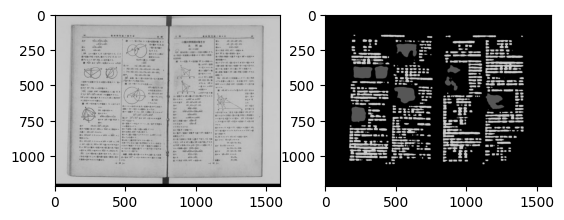

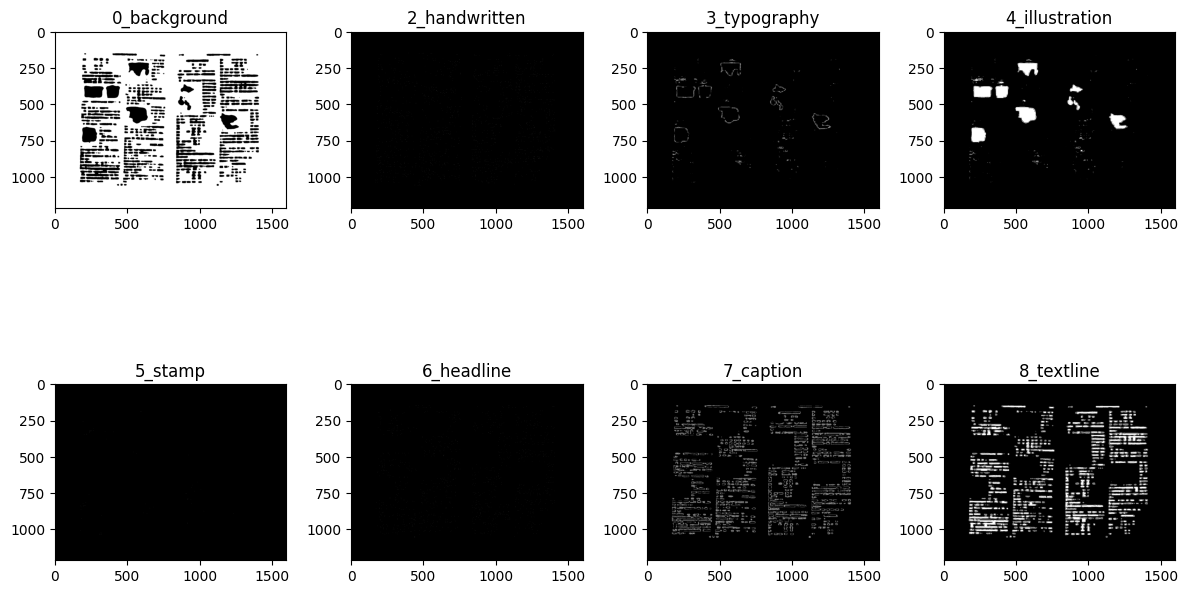

In [24]:
import math
import matplotlib.pyplot as plt
import random

pred_dirs = list(pred_dir.iterdir())
random.shuffle(pred_dirs)
for pred_path in pred_dirs:
    print(pred_path.as_posix())
    core_fig, core_ax = plt.subplots(1, 2)
    original_path = pred_path.parent.parent / "images" / pred_path.name    
    pred = cv2.imread(pred_path.as_posix(), 1).astype(np.uint8)
    original = cv2.imread(original_path.as_posix()).astype(np.uint8)
    pred = pred[:, :, 0]
    core_ax[0].imshow(original)
    core_ax[1].imshow(pred, cmap="gray")    
    pred = np.array(pred)
    pred //= 25
    
    fig, ax = plt.subplots(ncols=4, nrows=math.ceil(len(CLASS_MAP) / 4))
    fig.set_size_inches(12, 8)
    
    for index, key in CLASS_MAP.items():        
        img = pred.copy()
        sub = ax[index // 4][index % 4]
        pred_pil = (pred == index) * 25
        sub.imshow(pred_pil, cmap="gray")
        sub.set_title(key)
        
        # Convert the segmentation mask to bounding boxes
        bboxes = mask_to_bboxes(img, remove_noise_flag=False)

        print("Bounding boxes:", bboxes)
        
    fig.tight_layout()
    break